# Check angle distribution DURING last scan

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.stats import iqr

In [2]:
from pp_utils.core import generate_data_path_dict, MISC_PARAMS
from pp_utils.file_handling import df_main_loader
from pp_utils import utils
import pp_utils.inspection_angle as ia

In [3]:
import pickle

## Set paths, load main info df and clusters

In [4]:
data_path = generate_data_path_dict(Path("../data_processed/"))
raw_path = Path("../data_raw/")

### Data and output path

In [5]:
output_path = data_path["main"] / "data_summary"
tp_path = output_path / "trial_processor_object"

In [6]:
fig_path = Path("../figs")
if not fig_path.exists():
    fig_path.mkdir()

### Load main dataframe

In [7]:
df_main = df_main_loader(
    folder=data_path["info_csv"], filename="main_info_append_09.csv",
)

### Load clustering results

In [8]:
with open(output_path / "clustering_7_rostrum_only.pickle", "rb") as filein:
    cluster_fnameprefix_7 = pickle.load(filein)

### Load compiled trial info and track portion

In [9]:
df_summary = pd.read_csv(output_path / "data_summary_all.csv", index_col=0)

In [10]:
with open(output_path / "track_portion_all.pickle", "rb") as filein:
    df_track_portion_all = pickle.load(filein)

## Sort clusters

### 7clusters

In [11]:
# Clean up clusters
# 0: TC-straight, 1: TC-very curved, 2: TC-curved (need to change sequence to: 0-2-1)
# 3: CT-very curved, 4: CT-curved, 6: CT-straight (need to change sequence to: 6-4-3)
df_cluster_7 = []
for seq, fp_list in enumerate(cluster_fnameprefix_7):
    df_sel = utils.sort_df_in_cluster(fp_list, df_summary)
    df_cluster_7.append(df_sel)

In [12]:
# Change sequence
new_seq = [0, 2, 1, 6, 4, 3]
df_cluster_clean_7 = []
for seq in new_seq:
    df_cluster_clean_7.append(df_cluster_7[seq])

In [13]:
# Sanity check that we've swapped things correctly
print([len(df) for df in df_cluster_7])
print([len(df) for df in df_cluster_clean_7])

[16, 9, 16, 6, 8, 1, 23]
[16, 16, 9, 23, 8, 6]


In [14]:
CLUSTER_STR_7 = [
    "R+/Straight", "R+/Curved-1", "R+/Curved-2",
    "L+/Straight", "L+/Curved-1", "L+/Curved-2"
]

## Gather data for the last scan

In [15]:
# Click RL threshold
MISC_PARAMS["th_RL"]

140

### Functions

In [16]:
def get_clicks(trial_idx):
    # Load TrialProcessor object
    tp_obj_fname = tp_path / f"trial_{trial_idx:03d}.pickle"
    with open(tp_obj_fname, "rb") as filein:
        tp = pickle.load(filein)
    
    # Filter out only clicks during the last scan
    df_ch0 = utils.filter_clicks_during_last_scan(
        df_h=tp.df_hydro_ch0.copy(),
        th_RL=MISC_PARAMS["th_RL"],
        time_last_scan_start=tp.last_scan_start,
        time_last_scan_end=tp.last_scan_end
    )
    df_ch1 = utils.filter_clicks_during_last_scan(
        df_h=tp.df_hydro_ch1.copy(),
        th_RL=MISC_PARAMS["th_RL"],
        time_last_scan_start=tp.last_scan_start,
        time_last_scan_end=tp.last_scan_end
    )

    # Print if decision made before reaching range threshold
    if tp.last_scan_end < tp.last_scan_start:
        print(f"Trial {trial_idx}: last scan start/end time invalid!")

    # Check if any df is empty
    if isinstance(df_ch0, pd.DataFrame) and len(df_ch0) == 0:
        print(f"Trial {trial_idx}: df_ch0 is empty")
    if isinstance(df_ch1, pd.DataFrame) and len(df_ch1) == 0:
        print(f"Trial {trial_idx}: df_ch1 is empty")
    
    return df_ch0, df_ch1

In [17]:
def get_trial_angle_dist(
    trial_idx, col_name="enso_angle", **kwargs
):
    """
    kwargs include:
        - enso_bin
        - time_binning
        - count_type
        - bin_delta
        - density
    
    Use col_name="enso_angle_flip" to flip enso_angle first before binning
    """
    df_ch0, df_ch1 = get_clicks(trial_idx)

    # Create a column for flipped angle if specified
    if col_name == "enso_angle_flip":
        df_ch0["enso_angle_flip"] = ia.enso2spheroid_angle(df_ch0["enso_angle"])
        df_ch1["enso_angle_flip"] = ia.enso2spheroid_angle(df_ch1["enso_angle"])
    
    # Get angle span
    ch0_angle_span = df_ch0["enso_angle"].max() - df_ch0["enso_angle"].min()
    ch1_angle_span = df_ch1["enso_angle"].max() - df_ch1["enso_angle"].min()

    # Get distribution
    ch0_dist = ia.get_angle_dist(df_click=df_ch0, col_name=col_name, **kwargs)
    ch1_dist = ia.get_angle_dist(df_click=df_ch1, col_name=col_name, **kwargs)
    
    return ch0_dist, ch1_dist, ch0_angle_span, ch1_angle_span

### Set up histgram params

In [18]:
enso_bin = np.arange(-90, 95, 3.75)
x_hist = (enso_bin[:-1] + enso_bin[1:])/2

In [19]:
enso_bin_size = enso_bin[1] - enso_bin[0]

In [20]:
binning_params = {
    "angle_bin": enso_bin,
    "time_binning": False,
    "density": False,
}

In [21]:
plot_params_ch0 = {
    "alpha": 0.5,
    "edgecolor": "k",
    "facecolor": "C0",
    "linewidth": 1
}
plot_params_ch1 = plot_params_ch0.copy()
plot_params_ch1["facecolor"] = "C1"

## Based on scenarios

### CT2 (L+/45) trials

In [22]:
scenario = "CT2"
df_list = []
for df_cluster, cluster_name in zip(df_cluster_clean_7, CLUSTER_STR_7):  # loop through all clusters
    # Find trials of a specific scenario
    print(cluster_name)
    num_scenario_trials = (df_cluster["TARGET_ANGLE"] == scenario).sum()
    if num_scenario_trials > 0:  # contain CT2 trials
        df_list.append(df_cluster[df_cluster["TARGET_ANGLE"] == scenario])
        print(f"   {num_scenario_trials} {scenario} trials")
    else:
        df_list.append([])
        print(f"   no {scenario} trials")

R+/Straight
   no CT2 trials
R+/Curved-1
   no CT2 trials
R+/Curved-2
   no CT2 trials
L+/Straight
   2 CT2 trials
L+/Curved-1
   2 CT2 trials
L+/Curved-2
   4 CT2 trials


In [23]:
dff = df_list[-1]
dff

,scan_ch0,scan_ch1,scan_combined,time_decision,time_buzz_onset_dtag,time_buzz_onset_hydro,time_touch,time_last_nonchosen,range_decision_tar,range_buzz_onset_dtag_tar,...,CHOICE,TARGET_ANGLE,fname_prefix,TRIAL_TO_INCLUDE,time_buzz_onset_clean,time_decision2touch,time_buzz2touch,range_buzz_onset_tar_clean,range_buzz_onset_clu_clean,range_buzz_onset_closest
82,7.0,7.0,11.0,954.279593,955.679057,955.681405,958.390738,0.722616,1.569528,0.939445,...,1,CT2,20190627_s3_t5,Y,955.679057,4.111144,2.711681,0.939445,1.088683,0.939445
217,7.0,7.0,12.0,557.387621,558.817279,558.817331,560.793514,0.298168,1.392069,0.860357,...,1,CT2,20190704_s1_t4,Y,558.817279,3.405892,1.976234,0.860357,0.698801,0.860357
117,9.0,8.0,14.0,805.193403,806.857281,806.859485,811.141934,0.589734,1.750208,1.190464,...,1,CT2,20190628_s3_t7,Y,806.857281,5.948530,4.284653,1.190464,1.045234,1.190464
182,6.0,5.0,10.0,1097.789983,1096.947467,1096.735189,1101.533444,1.170276,1.396037,1.458839,...,1,CT2,20190702_s3_t10,Y,1096.735189,3.743461,4.798255,1.442693,1.150435,1.150435


Trial index=86
Trial 86: df_ch0 is empty
Ch1 angle span=0.604 deg


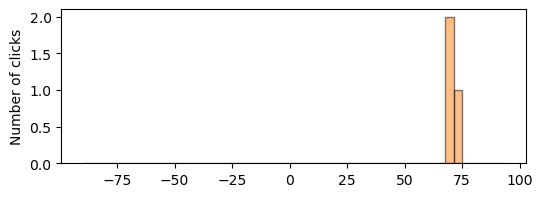

Trial index=237
Trial 237: df_ch0 is empty
Ch1 angle span=0.992 deg


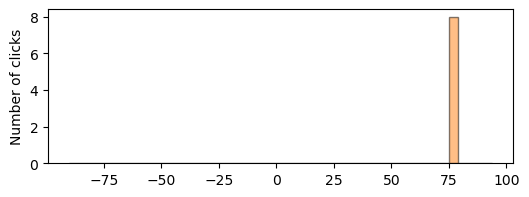

In [24]:
# L+/Straight
# Loop through all trials within this particular cluster under a specific scenario
for trial_idx in df_list[-3].index:
    print(f"Trial index={trial_idx}")
    ch0_dist, ch1_dist, ch0_angle_span, ch1_angle_span = get_trial_angle_dist(
        trial_idx,
        col_name="enso_angle_flip",
        **binning_params,
    )
    print(f"Ch1 angle span={ch1_angle_span:3.3f} deg")

    # If buzz initiated during last scan
    if df_summary.loc[trial_idx]["time_buzz_onset_clean"] < df_summary.loc[trial_idx]["time_decision"]:
        print("Buzz initiated during last scan!")

    plt.figure(figsize=(6,2))
    plt.bar(x=x_hist, width=enso_bin_size, height=ch1_dist, **plot_params_ch1)
    plt.ylabel("Number of clicks")
    plt.show()

Trial index=207
Trial 207: df_ch0 is empty
Ch1 angle span=1.106 deg


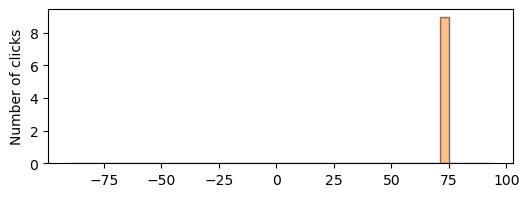

Trial index=235
Trial 235: df_ch0 is empty
Ch1 angle span=7.523 deg


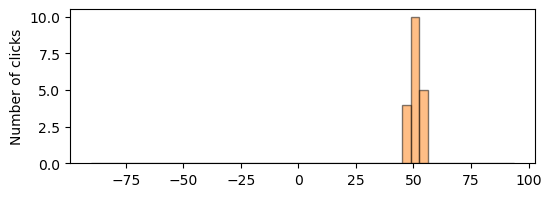

In [25]:
# L+/Curved-1
# Loop through all trials within this particular cluster under a specific scenario
for trial_idx in df_list[-2].index:
    print(f"Trial index={trial_idx}")
    ch0_dist, ch1_dist, ch0_angle_span, ch1_angle_span = get_trial_angle_dist(
        trial_idx,
        col_name="enso_angle_flip",
        **binning_params,
    )
    print(f"Ch1 angle span={ch1_angle_span:3.3f} deg")

    # If buzz initiated during last scan
    if df_summary.loc[trial_idx]["time_buzz_onset_clean"] < df_summary.loc[trial_idx]["time_decision"]:
        print("Buzz initiated during last scan!")

    plt.figure(figsize=(6,2))
    plt.bar(x=x_hist, width=enso_bin_size, height=ch1_dist, **plot_params_ch1)
    plt.ylabel("Number of clicks")
    plt.show()

Trial index=82
Trial 82: df_ch0 is empty
Ch1 angle span=19.257 deg


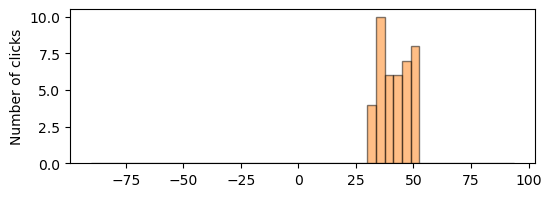

Trial index=217
Trial 217: df_ch0 is empty
Ch1 angle span=2.374 deg


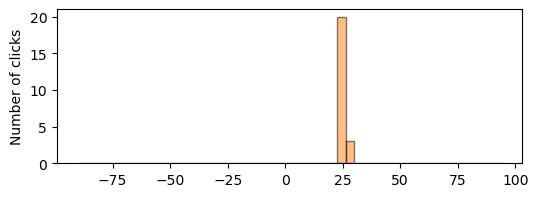

Trial index=117
Trial 117: df_ch0 is empty
Ch1 angle span=12.331 deg


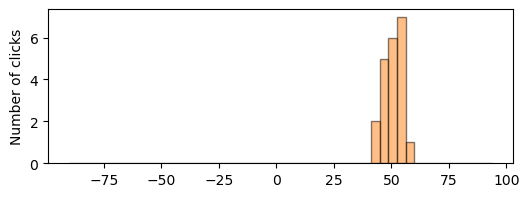

Trial index=182
Trial 182: df_ch0 is empty
Ch1 angle span=42.500 deg
Buzz initiated during last scan!


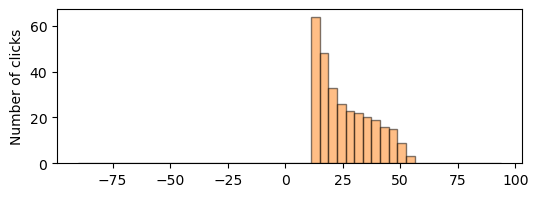

In [26]:
# L+/Curved-2
# Loop through all trials within this particular cluster under a specific scenario
for trial_idx in df_list[-1].index:
    print(f"Trial index={trial_idx}")
    ch0_dist, ch1_dist, ch0_angle_span, ch1_angle_span = get_trial_angle_dist(
        trial_idx,
        col_name="enso_angle_flip",
        **binning_params,
    )
    print(f"Ch1 angle span={ch1_angle_span:3.3f} deg")

    # If buzz initiated during last scan
    if df_summary.loc[trial_idx]["time_buzz_onset_clean"] < df_summary.loc[trial_idx]["time_decision"]:
        print("Buzz initiated during last scan!")

    plt.figure(figsize=(6,2))
    plt.bar(x=x_hist, width=enso_bin_size, height=ch1_dist, **plot_params_ch1)
    plt.ylabel("Number of clicks")
    plt.show()

### TC3 (R+/90) trials

In [27]:
scenario = "TC3"
df_list = []
for df_cluster, cluster_name in zip(df_cluster_clean_7, CLUSTER_STR_7):  # loop through all clusters
    # Find trials of a specific scenario
    print(cluster_name)
    num_scenario_trials = (df_cluster["TARGET_ANGLE"] == scenario).sum()
    if num_scenario_trials > 0:  # contain TC3 trials
        df_list.append(df_cluster[df_cluster["TARGET_ANGLE"] == scenario])
        print(f"   {num_scenario_trials} {scenario} trials")
    else:
        df_list.append([])
        print(f"   no {scenario} trials")

R+/Straight
   3 TC3 trials
R+/Curved-1
   2 TC3 trials
R+/Curved-2
   5 TC3 trials
L+/Straight
   no TC3 trials
L+/Curved-1
   no TC3 trials
L+/Curved-2
   no TC3 trials


In [28]:
dff = df_list[2]
dff

,scan_ch0,scan_ch1,scan_combined,time_decision,time_buzz_onset_dtag,time_buzz_onset_hydro,time_touch,time_last_nonchosen,range_decision_tar,range_buzz_onset_dtag_tar,...,CHOICE,TARGET_ANGLE,fname_prefix,TRIAL_TO_INCLUDE,time_buzz_onset_clean,time_decision2touch,time_buzz2touch,range_buzz_onset_tar_clean,range_buzz_onset_clu_clean,range_buzz_onset_closest
92,6.0,6.0,11.0,1012.773915,1012.189570,1012.192045,1015.613447,1.423826,1.283514,1.631043,...,1,TC3,20190628_s1_t4,Y,1012.192045,2.839532,3.421402,1.629222,1.200666,1.200666
159,6.0,6.0,11.0,967.353793,968.681621,968.695065,970.400425,1.674912,1.643740,0.971405,...,1,TC3,20190702_s1_t8,Y,968.681621,3.046632,1.718804,0.971405,0.919408,0.971405
129,3.0,3.0,6.0,1529.044347,1527.831991,1527.821865,1531.694290,2.783156,0.887462,1.294671,...,1,TC3,20190701_s1_t9,Y,1527.821865,2.649943,3.872425,1.306821,1.068208,1.068208
218,7.0,7.0,11.0,665.008168,665.405566,665.417616,667.164437,0.897490,0.836412,0.722375,...,1,TC3,20190704_s1_t5,Y,665.405566,2.156269,1.758872,0.722375,0.864386,0.722375
176,5.0,5.0,9.0,711.424518,712.891885,712.901692,715.080646,1.175890,1.568370,1.089565,...,1,TC3,20190702_s3_t4,Y,712.891885,3.656128,2.188760,1.089565,0.914709,1.089565


Trial index=191
Ch1 angle span=3.999 deg


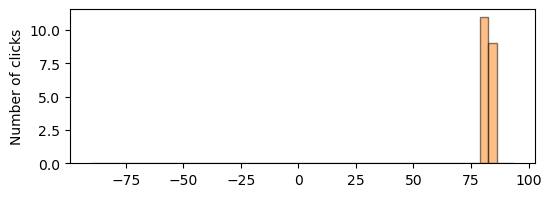

Trial index=127
Ch1 angle span=2.413 deg


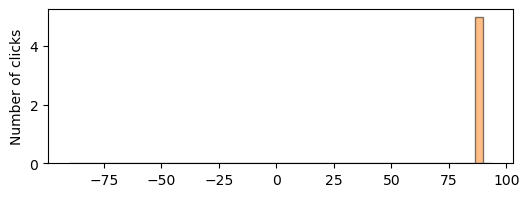

Trial index=85
Trial 85: df_ch0 is empty
Ch1 angle span=8.155 deg


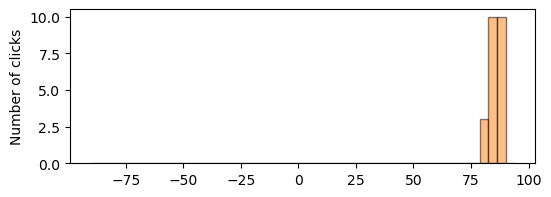

In [29]:
# R+/Straight
# Loop through all trials within this particular cluster under a specific scenario
for trial_idx in df_list[0].index:
    print(f"Trial index={trial_idx}")
    ch0_dist, ch1_dist, ch0_angle_span, ch1_angle_span = get_trial_angle_dist(
        trial_idx,
        col_name="enso_angle_flip",
        **binning_params,
    )
    print(f"Ch1 angle span={ch1_angle_span:3.3f} deg")

    # If buzz initiated during last scan
    if df_summary.loc[trial_idx]["time_buzz_onset_clean"] < df_summary.loc[trial_idx]["time_decision"]:
        print("Buzz initiated during last scan!")

    plt.figure(figsize=(6,2))
    plt.bar(x=x_hist, width=enso_bin_size, height=ch1_dist, **plot_params_ch1)
    plt.ylabel("Number of clicks")
    plt.show()

Trial index=179
Ch1 angle span=3.528 deg


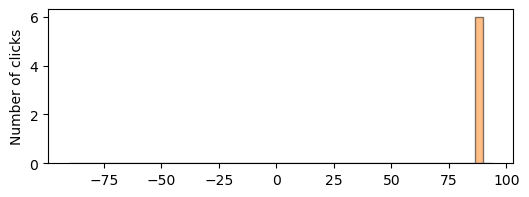

Trial index=189
Trial 189: df_ch0 is empty
Ch1 angle span=9.121 deg


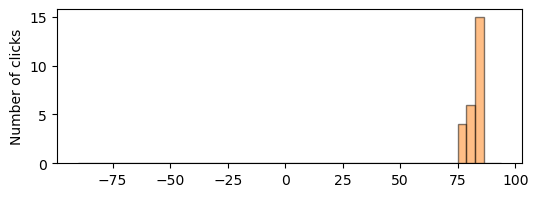

In [30]:
# R+/Curved-1
# Loop through all trials within this particular cluster under a specific scenario
for trial_idx in df_list[1].index:
    print(f"Trial index={trial_idx}")
    ch0_dist, ch1_dist, ch0_angle_span, ch1_angle_span = get_trial_angle_dist(
        trial_idx,
        col_name="enso_angle_flip",
        **binning_params,
    )
    print(f"Ch1 angle span={ch1_angle_span:3.3f} deg")

    # If buzz initiated during last scan
    if df_summary.loc[trial_idx]["time_buzz_onset_clean"] < df_summary.loc[trial_idx]["time_decision"]:
        print("Buzz initiated during last scan!")

    plt.figure(figsize=(6,2))
    plt.bar(x=x_hist, width=enso_bin_size, height=ch1_dist, **plot_params_ch1)
    plt.ylabel("Number of clicks")
    plt.show()

Trial index=92
Ch1 angle span=19.566 deg
Buzz initiated during last scan!


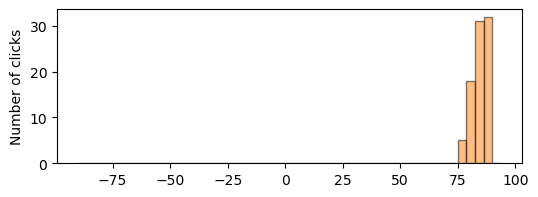

Trial index=159
Ch1 angle span=3.590 deg


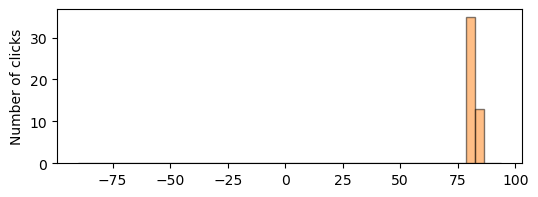

Trial index=129
Trial 129: df_ch0 is empty
Ch1 angle span=39.823 deg
Buzz initiated during last scan!


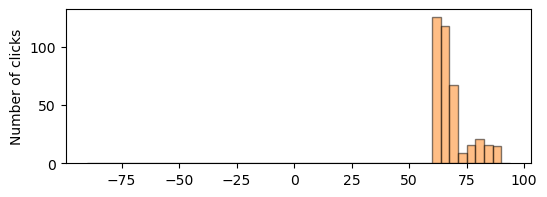

Trial index=218
Trial 218: df_ch0 is empty
Ch1 angle span=15.282 deg


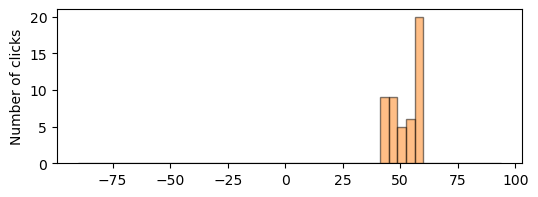

Trial index=176
Trial 176: df_ch0 is empty
Ch1 angle span=2.532 deg


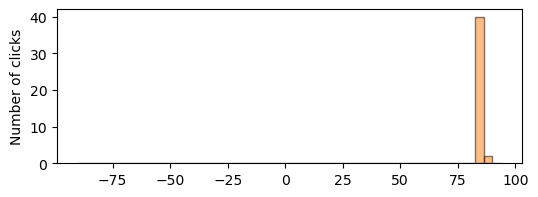

In [31]:
# R+/Curved-2
# Loop through all trials within this particular cluster under a specific scenario
for trial_idx in df_list[2].index:
    print(f"Trial index={trial_idx}")
    ch0_dist, ch1_dist, ch0_angle_span, ch1_angle_span = get_trial_angle_dist(
        trial_idx,
        col_name="enso_angle_flip",
        **binning_params,
    )
    print(f"Ch1 angle span={ch1_angle_span:3.3f} deg")

    # If buzz initiated during last scan
    if df_summary.loc[trial_idx]["time_buzz_onset_clean"] < df_summary.loc[trial_idx]["time_decision"]:
        print("Buzz initiated during last scan!")

    plt.figure(figsize=(6,2))
    plt.bar(x=x_hist, width=enso_bin_size, height=ch1_dist, **plot_params_ch1)
    plt.ylabel("Number of clicks")
    plt.show()

### TC4 (R+/135) trials

In [32]:
scenario = "TC4"
df_list = []
for df_cluster, cluster_name in zip(df_cluster_clean_7, CLUSTER_STR_7):  # loop through all clusters
    # Find trials of a specific scenario
    print(cluster_name)
    num_scenario_trials = (df_cluster["TARGET_ANGLE"] == scenario).sum()
    if num_scenario_trials > 0:  # contain TC4 trials
        df_list.append(df_cluster[df_cluster["TARGET_ANGLE"] == scenario])
        print(f"   {num_scenario_trials} {scenario} trials")
    else:
        df_list.append([])
        print(f"   no {scenario} trials")

R+/Straight
   1 TC4 trials
R+/Curved-1
   7 TC4 trials
R+/Curved-2
   3 TC4 trials
L+/Straight
   no TC4 trials
L+/Curved-1
   no TC4 trials
L+/Curved-2
   no TC4 trials


In [33]:
dff = df_list[2]
dff

,scan_ch0,scan_ch1,scan_combined,time_decision,time_buzz_onset_dtag,time_buzz_onset_hydro,time_touch,time_last_nonchosen,range_decision_tar,range_buzz_onset_dtag_tar,...,CHOICE,TARGET_ANGLE,fname_prefix,TRIAL_TO_INCLUDE,time_buzz_onset_clean,time_decision2touch,time_buzz2touch,range_buzz_onset_tar_clean,range_buzz_onset_clu_clean,range_buzz_onset_closest
161,5.0,5.0,9.0,1081.436671,1080.836746,1080.863067,1084.081286,0.722478,1.154622,1.533768,...,1,TC4,20190702_s1_t10,Y,1080.836746,2.644615,3.244540,1.533768,0.990227,0.990227
212,8.0,6.0,13.0,841.736687,842.567465,842.591215,845.276268,0.279036,1.491866,0.971032,...,1,TC4,20190703_s3_t9,Y,842.567465,3.539582,2.708804,0.971032,0.978279,0.971032
239,6.0,5.0,9.0,593.906337,593.534783,593.527127,596.595842,1.278598,0.896364,1.062719,...,1,TC4,20190704_s3_t5,Y,593.527127,2.689505,3.068715,1.062371,0.971725,0.971725


Trial index=186
Ch1 angle span=0.261 deg


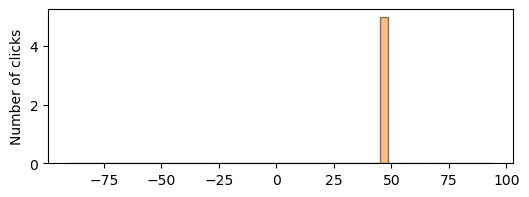

In [34]:
# R+/Straight
# Loop through all trials within this particular cluster under a specific scenario
for trial_idx in df_list[0].index:
    print(f"Trial index={trial_idx}")
    ch0_dist, ch1_dist, ch0_angle_span, ch1_angle_span = get_trial_angle_dist(
        trial_idx,
        col_name="enso_angle_flip",
        **binning_params,
    )
    print(f"Ch1 angle span={ch1_angle_span:3.3f} deg")

    # If buzz initiated during last scan
    if df_summary.loc[trial_idx]["time_buzz_onset_clean"] < df_summary.loc[trial_idx]["time_decision"]:
        print("Buzz initiated during last scan!")

    plt.figure(figsize=(6,2))
    plt.bar(x=x_hist, width=enso_bin_size, height=ch1_dist, **plot_params_ch1)
    plt.ylabel("Number of clicks")
    plt.show()

Trial index=183
Trial 183: df_ch0 is empty
Ch1 angle span=3.967 deg


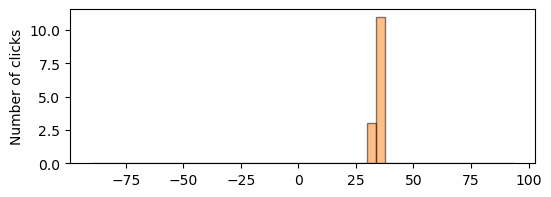

Trial index=125
Trial 125: df_ch0 is empty
Ch1 angle span=10.421 deg


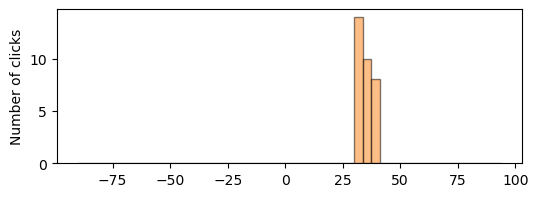

Trial index=139
Ch1 angle span=1.069 deg


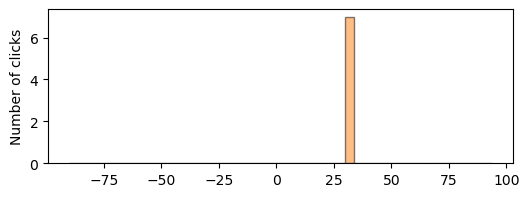

Trial index=123
Trial 123: df_ch0 is empty
Ch1 angle span=9.361 deg


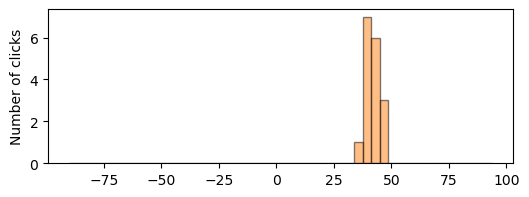

Trial index=240
Trial 240: df_ch0 is empty
Ch1 angle span=7.603 deg


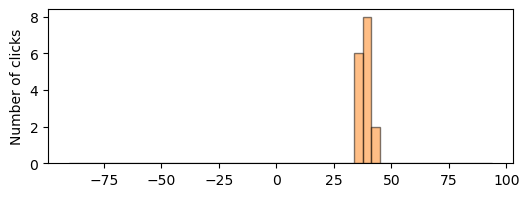

Trial index=246
Trial 246: df_ch0 is empty
Ch1 angle span=6.701 deg


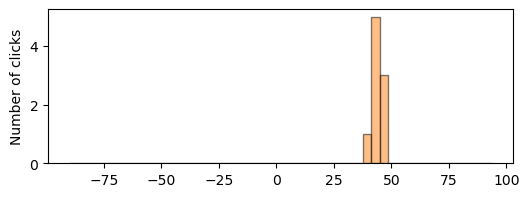

Trial index=188
Trial 188: df_ch0 is empty
Ch1 angle span=21.257 deg
Buzz initiated during last scan!


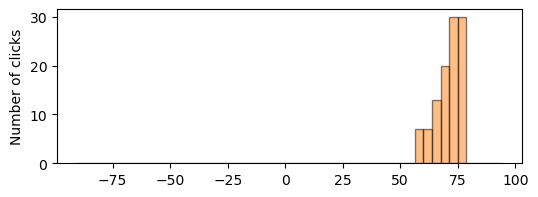

In [35]:
# R+/Curved-1
# Loop through all trials within this particular cluster under a specific scenario
for trial_idx in df_list[1].index:
    print(f"Trial index={trial_idx}")
    ch0_dist, ch1_dist, ch0_angle_span, ch1_angle_span = get_trial_angle_dist(
        trial_idx,
        col_name="enso_angle_flip",
        **binning_params,
    )
    print(f"Ch1 angle span={ch1_angle_span:3.3f} deg")

    # If buzz initiated during last scan
    if df_summary.loc[trial_idx]["time_buzz_onset_clean"] < df_summary.loc[trial_idx]["time_decision"]:
        print("Buzz initiated during last scan!")

    plt.figure(figsize=(6,2))
    plt.bar(x=x_hist, width=enso_bin_size, height=ch1_dist, **plot_params_ch1)
    plt.ylabel("Number of clicks")
    plt.show()

Trial index=161
Trial 161: df_ch0 is empty
Ch1 angle span=16.464 deg
Buzz initiated during last scan!


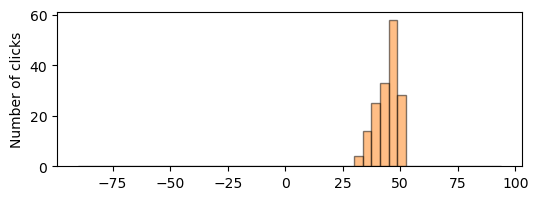

Trial index=212
Trial 212: df_ch0 is empty
Ch1 angle span=6.955 deg


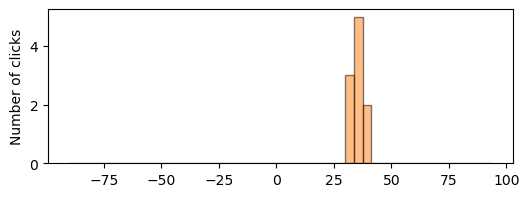

Trial index=239
Trial 239: df_ch0 is empty
Ch1 angle span=9.635 deg
Buzz initiated during last scan!


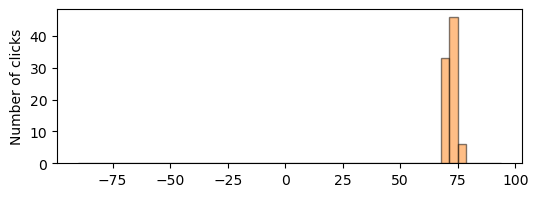

In [36]:
# R+/Curved-2
# Loop through all trials within this particular cluster under a specific scenario
for trial_idx in df_list[2].index:
    print(f"Trial index={trial_idx}")
    ch0_dist, ch1_dist, ch0_angle_span, ch1_angle_span = get_trial_angle_dist(
        trial_idx,
        col_name="enso_angle_flip",
        **binning_params,
    )
    print(f"Ch1 angle span={ch1_angle_span:3.3f} deg")

    # If buzz initiated during last scan
    if df_summary.loc[trial_idx]["time_buzz_onset_clean"] < df_summary.loc[trial_idx]["time_decision"]:
        print("Buzz initiated during last scan!")

    plt.figure(figsize=(6,2))
    plt.bar(x=x_hist, width=enso_bin_size, height=ch1_dist, **plot_params_ch1)
    plt.ylabel("Number of clicks")
    plt.show()

## Based on clusters

In [37]:
# Scenarios
SCENARIO_STR = [
    "TC1", "TC2", "TC3", "TC4",
    "CT1", "CT2", "CT3", "CT4",
]

### R+/Curved-2

In [38]:
cluster_idx = -1
df_cluster = df_cluster_clean_7[cluster_idx]
print(CLUSTER_STR_7[cluster_idx])
for tca in SCENARIO_STR:
    df_tca = df_cluster[df_cluster["TARGET_ANGLE"] == tca]
    print(f"{tca}: {len(df_tca)} trials in this cluster")

L+/Curved-2
TC1: 0 trials in this cluster
TC2: 0 trials in this cluster
TC3: 0 trials in this cluster
TC4: 0 trials in this cluster
CT1: 0 trials in this cluster
CT2: 4 trials in this cluster
CT3: 1 trials in this cluster
CT4: 1 trials in this cluster


In [39]:
str_all = []
ch1_dist_all = []
buzz_str = ""
for tca in SCENARIO_STR:
    df_tca = df_cluster[df_cluster["TARGET_ANGLE"] == tca]
    if len(df_tca) == 0:
        continue

    # if trials exist under this scenario
    for trial_idx in df_tca.index:
        print(f"----- Trial index={trial_idx} ----------")
        ch0_dist, ch1_dist, ch0_angle_span, ch1_angle_span = get_trial_angle_dist(
            trial_idx,
            col_name="enso_angle_flip",
            **binning_params,
        )
        print(f"Ch1 angle span={ch1_angle_span:3.3f} deg")

        # If buzz initiated during last scan
        if df_summary.loc[trial_idx]["time_buzz_onset_clean"] < df_summary.loc[trial_idx]["time_decision"]:
            print("Buzz initiated during last scan!")
            buzz_str = "buzz"
        else:
            buzz_str = ""

        ch1_dist_all.append(ch1_dist)

        str_trial = f"{buzz_str} {tca} t{trial_idx:03d}"
        str_all.append(str_trial)
        print(str_trial)

ch1_dist_all_mtx = np.array(ch1_dist_all)
ch1_dist_all_mtx_norm = (ch1_dist_all_mtx.T / ch1_dist_all_mtx.sum(axis=1)).T

----- Trial index=82 ----------
Trial 82: df_ch0 is empty
Ch1 angle span=19.257 deg
 CT2 t082
----- Trial index=217 ----------
Trial 217: df_ch0 is empty
Ch1 angle span=2.374 deg
 CT2 t217
----- Trial index=117 ----------
Trial 117: df_ch0 is empty
Ch1 angle span=12.331 deg
 CT2 t117
----- Trial index=182 ----------
Trial 182: df_ch0 is empty
Ch1 angle span=42.500 deg
Buzz initiated during last scan!
buzz CT2 t182
----- Trial index=121 ----------
Trial 121: df_ch0 is empty
Ch1 angle span=1.986 deg
 CT3 t121
----- Trial index=205 ----------
Trial 205: df_ch0 is empty
Ch1 angle span=1.511 deg
 CT4 t205


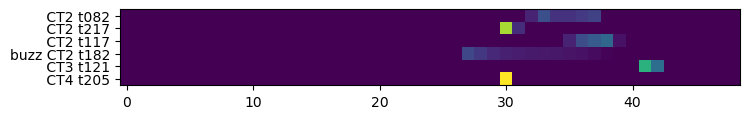

In [40]:
plt.figure(figsize=(8, 4))
plt.imshow(ch1_dist_all_mtx_norm)
plt.yticks(np.arange(ch1_dist_all_mtx_norm.shape[0]), str_all)
plt.show()

### L+/Curved-2

In [41]:
cluster_idx = 2
df_cluster = df_cluster_clean_7[cluster_idx]
print(CLUSTER_STR_7[cluster_idx])
for tca in SCENARIO_STR:
    df_tca = df_cluster[df_cluster["TARGET_ANGLE"] == tca]
    print(f"{tca}: {len(df_tca)} trials in this cluster")

R+/Curved-2
TC1: 1 trials in this cluster
TC2: 0 trials in this cluster
TC3: 5 trials in this cluster
TC4: 3 trials in this cluster
CT1: 0 trials in this cluster
CT2: 0 trials in this cluster
CT3: 0 trials in this cluster
CT4: 0 trials in this cluster


In [42]:
str_all = []
ch1_dist_all = []
buzz_str = ""
for tca in SCENARIO_STR:
    df_tca = df_cluster[df_cluster["TARGET_ANGLE"] == tca]
    if len(df_tca) == 0:
        continue

    # if trials exist under this scenario
    for trial_idx in df_tca.index:
        print(f"----- Trial index={trial_idx} ----------")
        ch0_dist, ch1_dist, ch0_angle_span, ch1_angle_span = get_trial_angle_dist(
            trial_idx,
            col_name="enso_angle_flip",
            **binning_params,
        )
        print(f"Ch1 angle span={ch1_angle_span:3.3f} deg")

        # If buzz initiated during last scan
        if df_summary.loc[trial_idx]["time_buzz_onset_clean"] < df_summary.loc[trial_idx]["time_decision"]:
            print("Buzz initiated during last scan!")
            buzz_str = "buzz"
        else:
            buzz_str = ""

        ch1_dist_all.append(ch1_dist)

        str_trial = f"{buzz_str} {tca} t{trial_idx:03d}"
        str_all.append(str_trial)
        print(str_trial)

ch1_dist_all_mtx = np.array(ch1_dist_all)
ch1_dist_all_mtx_norm = (ch1_dist_all_mtx.T / ch1_dist_all_mtx.sum(axis=1)).T

----- Trial index=78 ----------
Trial 78: df_ch0 is empty
Ch1 angle span=12.777 deg
Buzz initiated during last scan!
buzz TC1 t078
----- Trial index=92 ----------
Ch1 angle span=19.566 deg
Buzz initiated during last scan!
buzz TC3 t092
----- Trial index=159 ----------
Ch1 angle span=3.590 deg
 TC3 t159
----- Trial index=129 ----------
Trial 129: df_ch0 is empty
Ch1 angle span=39.823 deg
Buzz initiated during last scan!
buzz TC3 t129
----- Trial index=218 ----------
Trial 218: df_ch0 is empty
Ch1 angle span=15.282 deg
 TC3 t218
----- Trial index=176 ----------
Trial 176: df_ch0 is empty
Ch1 angle span=2.532 deg
 TC3 t176
----- Trial index=161 ----------
Trial 161: df_ch0 is empty
Ch1 angle span=16.464 deg
Buzz initiated during last scan!
buzz TC4 t161
----- Trial index=212 ----------
Trial 212: df_ch0 is empty
Ch1 angle span=6.955 deg
 TC4 t212
----- Trial index=239 ----------
Trial 239: df_ch0 is empty
Ch1 angle span=9.635 deg
Buzz initiated during last scan!
buzz TC4 t239


In [43]:
ch1_dist_all_mtx_norm.shape

(9, 49)

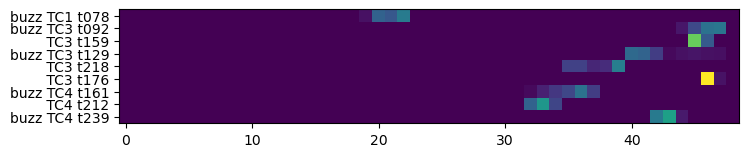

In [44]:
plt.figure(figsize=(8, 4))
plt.imshow(ch1_dist_all_mtx_norm)
plt.yticks(np.arange(ch1_dist_all_mtx_norm.shape[0]), str_all)
plt.show()

## All clusters

R+/Straight
----- Trial index=242 ----------
Trial 242: df_ch0 is empty
Ch1 angle span=6.158 deg
----- Trial index=223 ----------
Trial 223: df_ch0 is empty
Ch1 angle span=3.692 deg
----- Trial index=238 ----------
Ch1 angle span=0.459 deg
----- Trial index=96 ----------
Ch1 angle span=5.332 deg
----- Trial index=97 ----------
Ch1 angle span=0.865 deg
----- Trial index=236 ----------
Trial 236: df_ch0 is empty
Ch1 angle span=4.364 deg
----- Trial index=134 ----------
Trial 134: df_ch0 is empty
Ch1 angle span=1.408 deg
----- Trial index=215 ----------
Trial 215: df_ch0 is empty
Ch1 angle span=3.456 deg
----- Trial index=132 ----------
Trial 132: df_ch0 is empty
Ch1 angle span=5.384 deg
----- Trial index=112 ----------
Trial 112: df_ch0 is empty
Ch1 angle span=3.834 deg
----- Trial index=178 ----------
Ch1 angle span=0.970 deg
----- Trial index=89 ----------
Trial 89: df_ch0 is empty
Ch1 angle span=4.911 deg
----- Trial index=191 ----------
Ch1 angle span=3.999 deg
----- Trial index=127 

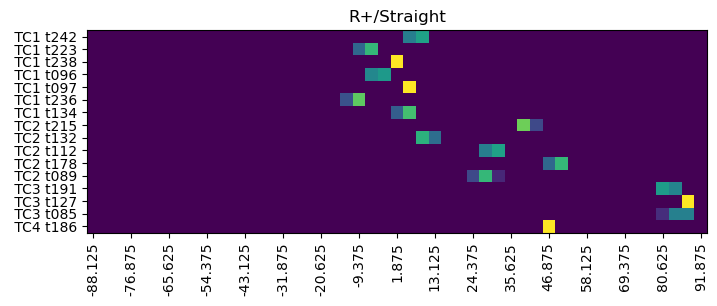

R+/Curved-1
----- Trial index=114 ----------
Trial 114: df_ch0 is empty
Ch1 angle span=2.819 deg
----- Trial index=80 ----------
Trial 80: df_ch0 is empty
Ch1 angle span=2.824 deg
----- Trial index=155 ----------
Trial 155: df_ch0 is empty
Ch1 angle span=3.463 deg
----- Trial index=216 ----------
Trial 216: df_ch0 is empty
Ch1 angle span=5.610 deg
----- Trial index=221 ----------
Trial 221: df_ch0 is empty
Ch1 angle span=3.676 deg
----- Trial index=135 ----------
Trial 135: df_ch0 is empty
Ch1 angle span=1.542 deg
----- Trial index=138 ----------
Ch1 angle span=2.465 deg
----- Trial index=179 ----------
Ch1 angle span=3.528 deg
----- Trial index=189 ----------
Trial 189: df_ch0 is empty
Ch1 angle span=9.121 deg
----- Trial index=183 ----------
Trial 183: df_ch0 is empty
Ch1 angle span=3.967 deg
----- Trial index=125 ----------
Trial 125: df_ch0 is empty
Ch1 angle span=10.421 deg
----- Trial index=139 ----------
Ch1 angle span=1.069 deg
----- Trial index=123 ----------
Trial 123: df_ch0

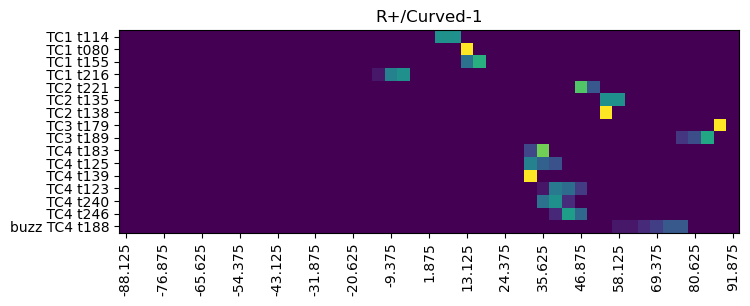

R+/Curved-2
----- Trial index=78 ----------
Trial 78: df_ch0 is empty
Ch1 angle span=12.777 deg
Buzz initiated during last scan!
----- Trial index=92 ----------
Ch1 angle span=19.566 deg
Buzz initiated during last scan!
----- Trial index=159 ----------
Ch1 angle span=3.590 deg
----- Trial index=129 ----------
Trial 129: df_ch0 is empty
Ch1 angle span=39.823 deg
Buzz initiated during last scan!
----- Trial index=218 ----------
Trial 218: df_ch0 is empty
Ch1 angle span=15.282 deg
----- Trial index=176 ----------
Trial 176: df_ch0 is empty
Ch1 angle span=2.532 deg
----- Trial index=161 ----------
Trial 161: df_ch0 is empty
Ch1 angle span=16.464 deg
Buzz initiated during last scan!
----- Trial index=212 ----------
Trial 212: df_ch0 is empty
Ch1 angle span=6.955 deg
----- Trial index=239 ----------
Trial 239: df_ch0 is empty
Ch1 angle span=9.635 deg
Buzz initiated during last scan!


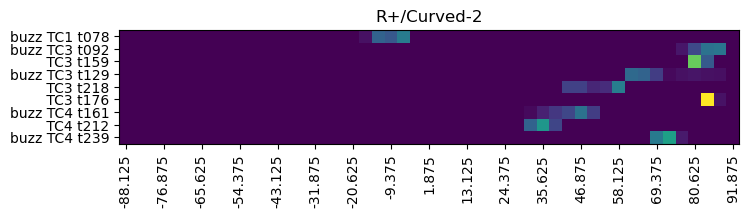

L+/Straight
----- Trial index=131 ----------
Ch1 angle span=3.062 deg
----- Trial index=84 ----------
Trial 84: df_ch0 is empty
Ch1 angle span=1.244 deg
----- Trial index=184 ----------
Trial 184: df_ch0 is empty
Ch1 angle span=3.518 deg
----- Trial index=111 ----------
Trial 111: df_ch0 is empty
Ch1 angle span=2.036 deg
----- Trial index=86 ----------
Trial 86: df_ch0 is empty
Ch1 angle span=0.604 deg
----- Trial index=237 ----------
Trial 237: df_ch0 is empty
Ch1 angle span=0.992 deg
----- Trial index=187 ----------
Ch1 angle span=0.062 deg
----- Trial index=91 ----------
Trial 91: df_ch0 is empty
Ch1 angle span=4.655 deg
----- Trial index=241 ----------
Trial 241: df_ch0 is empty
Ch1 angle span=0.552 deg
----- Trial index=243 ----------
Trial 243: df_ch0 is empty
Ch1 angle span=0.753 deg
----- Trial index=154 ----------
Trial 154: df_ch0 is empty
Ch1 angle span=1.509 deg
----- Trial index=160 ----------
Ch1 angle span=3.957 deg
----- Trial index=133 ----------
Trial 133: df_ch0 is e

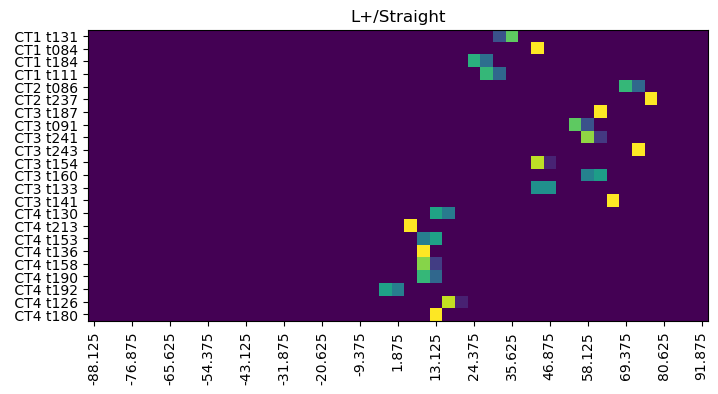

L+/Curved-1
----- Trial index=90 ----------
Trial 90: df_ch0 is empty
Ch1 angle span=1.118 deg
----- Trial index=219 ----------
Trial 219: df_ch0 is empty
Ch1 angle span=6.413 deg
Buzz initiated during last scan!
----- Trial index=207 ----------
Trial 207: df_ch0 is empty
Ch1 angle span=1.106 deg
----- Trial index=235 ----------
Trial 235: df_ch0 is empty
Ch1 angle span=7.523 deg
----- Trial index=79 ----------
Trial 79: df_ch0 is empty
Ch1 angle span=2.556 deg
----- Trial index=220 ----------
Trial 220: df_ch0 is empty
Ch1 angle span=1.845 deg
----- Trial index=181 ----------
Trial 181: df_ch0 is empty
Ch1 angle span=0.000 deg
----- Trial index=222 ----------
Trial 222: df_ch0 is empty
Ch1 angle span=1.456 deg


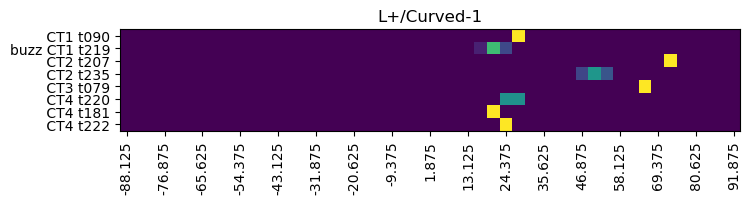

L+/Curved-2
----- Trial index=82 ----------
Trial 82: df_ch0 is empty
Ch1 angle span=19.257 deg
----- Trial index=217 ----------
Trial 217: df_ch0 is empty
Ch1 angle span=2.374 deg
----- Trial index=117 ----------
Trial 117: df_ch0 is empty
Ch1 angle span=12.331 deg
----- Trial index=182 ----------
Trial 182: df_ch0 is empty
Ch1 angle span=42.500 deg
Buzz initiated during last scan!
----- Trial index=121 ----------
Trial 121: df_ch0 is empty
Ch1 angle span=1.986 deg
----- Trial index=205 ----------
Trial 205: df_ch0 is empty
Ch1 angle span=1.511 deg


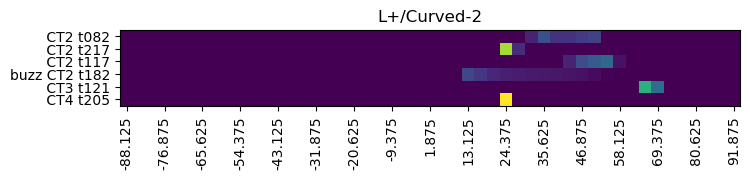

In [45]:
for cluster_idx in range(6):
    df_cluster = df_cluster_clean_7[cluster_idx]
    print(CLUSTER_STR_7[cluster_idx])
    for tca in SCENARIO_STR:
        df_tca = df_cluster[df_cluster["TARGET_ANGLE"] == tca]
        # print(f"{tca}: {len(df_tca)} trials in this cluster")

    str_all = []
    ch1_dist_all = []
    buzz_str = ""
    for tca in SCENARIO_STR:
        df_tca = df_cluster[df_cluster["TARGET_ANGLE"] == tca]
        if len(df_tca) == 0:
            continue

        # if trials exist under this scenario
        for trial_idx in df_tca.index:
            print(f"----- Trial index={trial_idx} ----------")
            ch0_dist, ch1_dist, ch0_angle_span, ch1_angle_span = get_trial_angle_dist(
                trial_idx,
                col_name="enso_angle_flip",
                **binning_params,
            )
            print(f"Ch1 angle span={ch1_angle_span:3.3f} deg")

            # If buzz initiated during last scan
            if df_summary.loc[trial_idx]["time_buzz_onset_clean"] < df_summary.loc[trial_idx]["time_decision"]:
                print("Buzz initiated during last scan!")
                buzz_str = "buzz"
            else:
                buzz_str = ""

            ch1_dist_all.append(ch1_dist)

            str_trial = f"{buzz_str} {tca} t{trial_idx:03d}"
            str_all.append(str_trial)

    ch1_dist_all_mtx = np.array(ch1_dist_all)
    ch1_dist_all_mtx_norm = (ch1_dist_all_mtx.T / ch1_dist_all_mtx.sum(axis=1)).T

    plt.figure(figsize=(8, 5))
    plt.imshow(ch1_dist_all_mtx_norm)
    plt.yticks(np.arange(ch1_dist_all_mtx_norm.shape[0]), str_all)
    plt.xticks(np.arange(ch1_dist_all_mtx_norm.shape[1])[::3], x_hist[::3], rotation=90)
    plt.title(CLUSTER_STR_7[cluster_idx])
    plt.show()

## Based on clusters

R+/Straight
----- Trial index=242 ----------
Trial 242: df_ch0 is empty
Trial 242: df_ch0 is empty
Ch1 angle span=6.158 deg
----- Trial index=223 ----------
Trial 223: df_ch0 is empty
Trial 223: df_ch0 is empty
Ch1 angle span=3.692 deg
----- Trial index=238 ----------
Ch1 angle span=0.459 deg
----- Trial index=96 ----------
Ch1 angle span=5.332 deg
----- Trial index=97 ----------
Ch1 angle span=0.865 deg
----- Trial index=236 ----------
Trial 236: df_ch0 is empty
Trial 236: df_ch0 is empty
Ch1 angle span=4.364 deg
----- Trial index=134 ----------
Trial 134: df_ch0 is empty
Trial 134: df_ch0 is empty
Ch1 angle span=1.408 deg
----- Trial index=215 ----------
Trial 215: df_ch0 is empty
Trial 215: df_ch0 is empty
Ch1 angle span=3.456 deg
----- Trial index=132 ----------
Trial 132: df_ch0 is empty
Trial 132: df_ch0 is empty
Ch1 angle span=5.384 deg
----- Trial index=112 ----------
Trial 112: df_ch0 is empty
Trial 112: df_ch0 is empty
Ch1 angle span=3.834 deg
----- Trial index=178 ----------

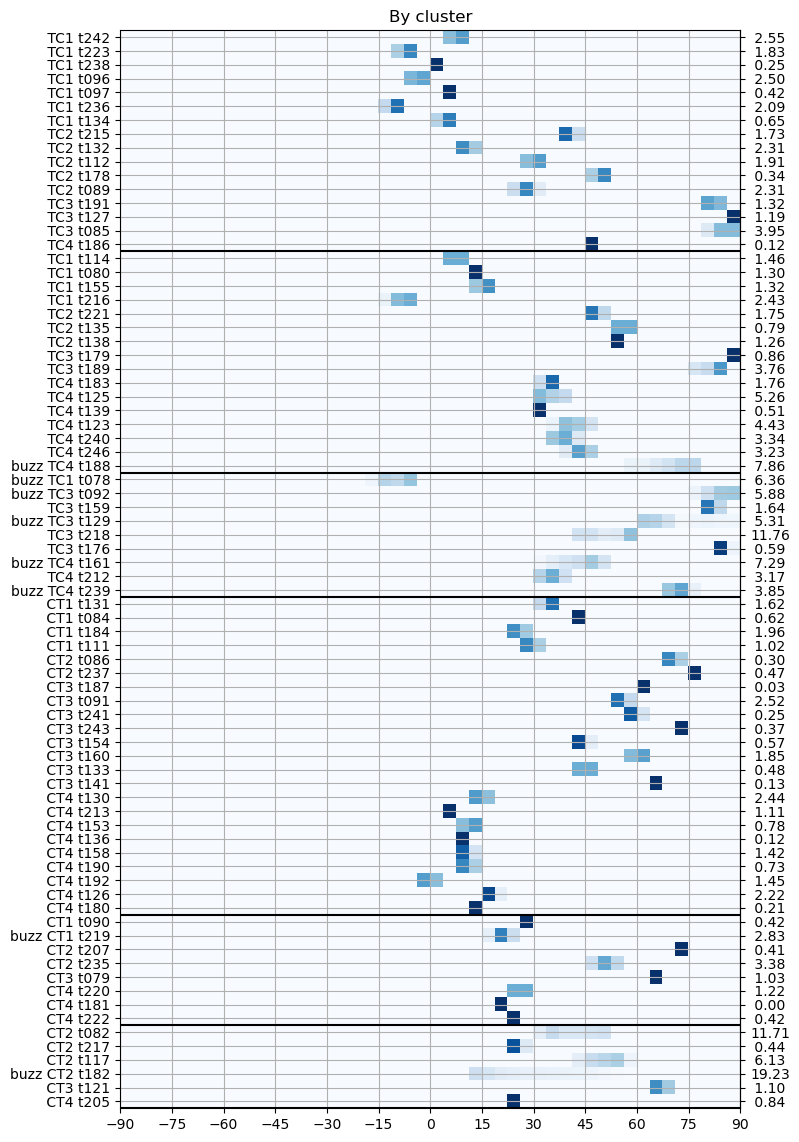

In [46]:
str_all = []
ch1_dist_all = []
iqr_cluster = dict()
iqr_all = []
iqr_buzz_all = []
iqr_regclick_all = []
iqr_str_all = []
trial_idx_all = []
buzz_str = ""
buzz_trial_idx = []
cluster_cut = []

for cluster_idx in range(6):
    df_cluster = df_cluster_clean_7[cluster_idx]
    print(CLUSTER_STR_7[cluster_idx])

    cluster_cut.append(len(df_cluster))
    iqr_cluster[CLUSTER_STR_7[cluster_idx]] = []  # store iqr within cluster

    for tca in SCENARIO_STR:
        df_tca = df_cluster[df_cluster["TARGET_ANGLE"] == tca]
        if len(df_tca) == 0:
            continue

        # if trials exist under this scenario
        for trial_idx in df_tca.index:
            print(f"----- Trial index={trial_idx} ----------")

            # get clicks
            _, df_ch1 = get_clicks(trial_idx)
            df_ch1["enso_angle_flip"] = ia.enso2spheroid_angle(df_ch1["enso_angle"])

            # get click distribution
            _, ch1_dist, _, ch1_angle_span = get_trial_angle_dist(
                trial_idx,
                col_name="enso_angle_flip",
                **binning_params,
            )
            print(f"Ch1 angle span={ch1_angle_span:3.3f} deg")

            # If buzz initiated during last scan
            if df_summary.loc[trial_idx]["time_buzz_onset_clean"] < df_summary.loc[trial_idx]["time_decision"]:
                print("Buzz initiated during last scan!")
                buzz_str = "buzz"
                buzz_trial_idx.append(trial_idx)
                iqr_buzz_all.append(iqr(df_ch1["enso_angle_flip"]))
            else:
                buzz_str = ""
                iqr_regclick_all.append(iqr(df_ch1["enso_angle_flip"]))

            ch1_dist_all.append(ch1_dist)

            trial_idx_all.append(trial_idx)

            str_trial = f"{buzz_str} {tca} t{trial_idx:03d}"
            str_all.append(str_trial)

            iqr_cluster[CLUSTER_STR_7[cluster_idx]].append(iqr(df_ch1["enso_angle_flip"]))
            iqr_all.append(iqr(df_ch1["enso_angle_flip"]))
            iqr_str_all.append(f"{iqr(df_ch1['enso_angle_flip']):5.2f}")

ch1_dist_all_mtx = np.array(ch1_dist_all)
ch1_dist_all_mtx_norm = (ch1_dist_all_mtx.T / ch1_dist_all_mtx.sum(axis=1)).T

plt.figure(figsize=(8, 14))
plt.imshow(
    ch1_dist_all_mtx_norm,
    extent=(-90, 93.75, 0, ch1_dist_all_mtx_norm.shape[0]),
    aspect="auto",
    origin="lower",
    cmap="Blues"
)
plt.yticks(np.arange(ch1_dist_all_mtx_norm.shape[0])+0.5, str_all)
plt.xticks(np.arange(-90, 100, 15))
plt.xlim(-90, 90)
plt.grid()

# Annotate iqr on the right
secax = plt.gca().secondary_yaxis('right')
secax.set_yticks(np.arange(ch1_dist_all_mtx_norm.shape[0])+0.5)
secax.set_yticklabels(iqr_str_all)

# Plot cluster cut
cluster_cut = np.cumsum(cluster_cut)
for cc in cluster_cut:
    plt.gca().axhline(y=cc, color="k")

plt.title("By cluster")
plt.gca().invert_yaxis()
plt.show()

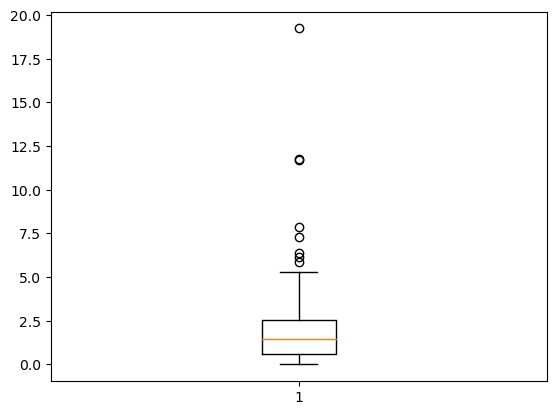

In [47]:
box_plot_dict = plt.boxplot(iqr_all)

In [48]:
[len(x) for x in iqr_cluster.values()]

[16, 16, 9, 23, 8, 6]

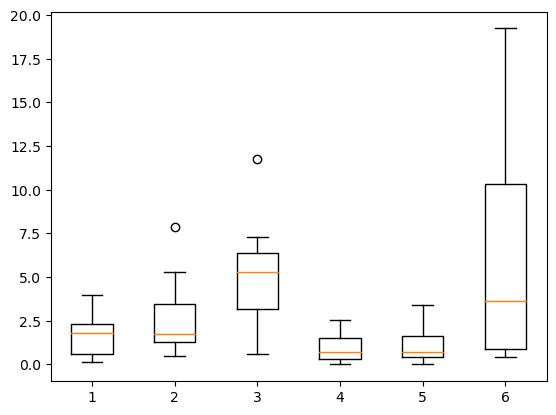

In [49]:
plt.boxplot(iqr_cluster.values())
plt.show()

## Based on scenarios

In [50]:
str_all = []
ch1_dist_all = []
iqr_all = []
iqr_str_all = []
buzz_str = ""
buzz_trial_idx = []
tca_cut = dict()

for tca in SCENARIO_STR:

    tca_cut[tca] = 0

    for cluster_idx in range(6):
        df_cluster = df_cluster_clean_7[cluster_idx]

        df_tca = df_cluster[df_cluster["TARGET_ANGLE"] == tca]
        tca_cut[tca] += len(df_tca)

        if len(df_tca) == 0:
            continue

        # if trials exist under this scenario
        for trial_idx in df_tca.index:
            print(f"----- Trial index={trial_idx} ----------")

            # get clicks
            _, df_ch1 = get_clicks(trial_idx)
            df_ch1["enso_angle_flip"] = ia.enso2spheroid_angle(df_ch1["enso_angle"])

            # get click distribution
            _, ch1_dist, _, ch1_angle_span = get_trial_angle_dist(
                trial_idx,
                col_name="enso_angle_flip",
                **binning_params,
            )
            print(f"Ch1 angle span={ch1_angle_span:3.3f} deg")

            # If buzz initiated during last scan
            if df_summary.loc[trial_idx]["time_buzz_onset_clean"] < df_summary.loc[trial_idx]["time_decision"]:
                print("Buzz initiated during last scan!")
                buzz_str = "buzz"
                buzz_trial_idx.append(trial_idx)
                iqr_buzz_all.append(iqr(df_ch1["enso_angle_flip"]))
            else:
                buzz_str = ""
                iqr_regclick_all.append(iqr(df_ch1["enso_angle_flip"]))

            ch1_dist_all.append(ch1_dist)

            str_trial = f"{buzz_str} {tca} t{trial_idx:03d}"
            str_all.append(str_trial)

            iqr_cluster[CLUSTER_STR_7[cluster_idx]].append(iqr(df_ch1["enso_angle_flip"]))
            iqr_all.append(iqr(df_ch1["enso_angle_flip"]))
            iqr_str_all.append(f"{iqr(df_ch1['enso_angle_flip']):5.2f}")


ch1_dist_all_mtx = np.array(ch1_dist_all)
ch1_dist_all_mtx_norm = (ch1_dist_all_mtx.T / ch1_dist_all_mtx.sum(axis=1)).T

----- Trial index=242 ----------
Trial 242: df_ch0 is empty
Trial 242: df_ch0 is empty
Ch1 angle span=6.158 deg
----- Trial index=223 ----------
Trial 223: df_ch0 is empty
Trial 223: df_ch0 is empty
Ch1 angle span=3.692 deg
----- Trial index=238 ----------
Ch1 angle span=0.459 deg
----- Trial index=96 ----------
Ch1 angle span=5.332 deg
----- Trial index=97 ----------
Ch1 angle span=0.865 deg
----- Trial index=236 ----------
Trial 236: df_ch0 is empty
Trial 236: df_ch0 is empty
Ch1 angle span=4.364 deg
----- Trial index=134 ----------
Trial 134: df_ch0 is empty
Trial 134: df_ch0 is empty
Ch1 angle span=1.408 deg
----- Trial index=114 ----------
Trial 114: df_ch0 is empty
Trial 114: df_ch0 is empty
Ch1 angle span=2.819 deg
----- Trial index=80 ----------
Trial 80: df_ch0 is empty
Trial 80: df_ch0 is empty
Ch1 angle span=2.824 deg
----- Trial index=155 ----------
Trial 155: df_ch0 is empty
Trial 155: df_ch0 is empty
Ch1 angle span=3.463 deg
----- Trial index=216 ----------
Trial 216: df_

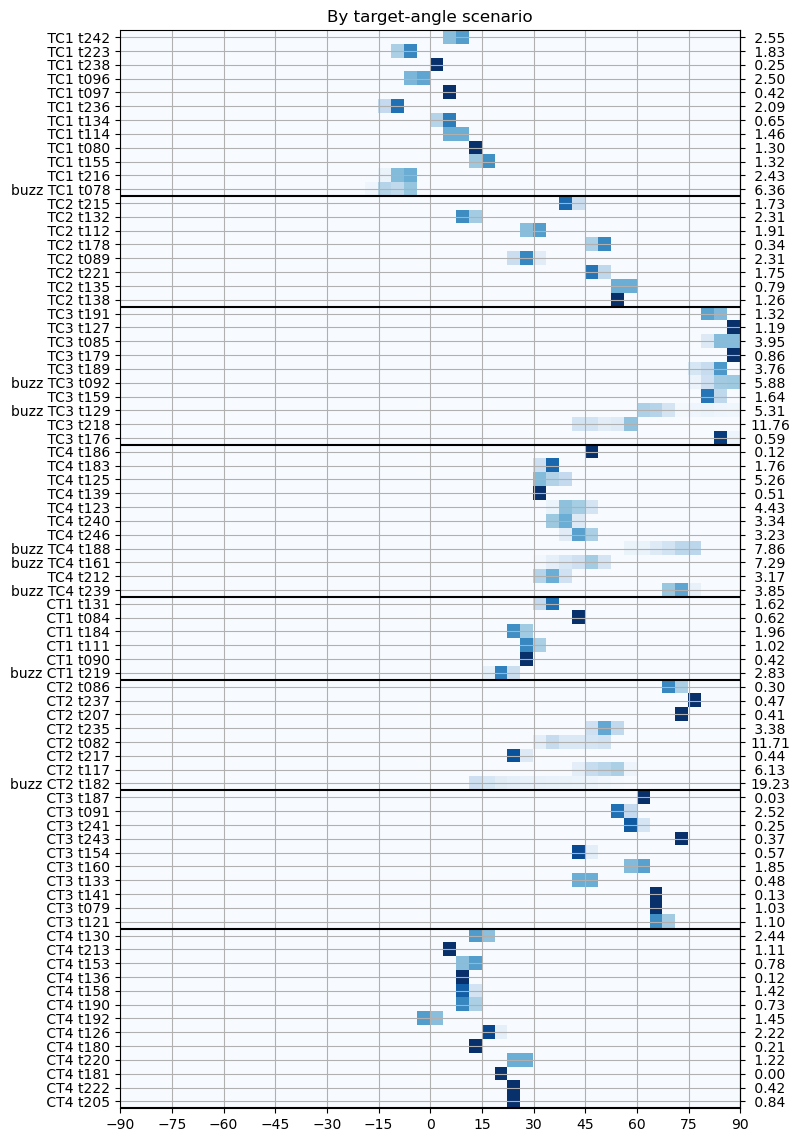

In [51]:
plt.figure(figsize=(8, 14))
plt.imshow(
    ch1_dist_all_mtx_norm,
    extent=(-90, 93.75, 0, ch1_dist_all_mtx_norm.shape[0]),
    aspect="auto",
    origin="lower",
    cmap="Blues"
)
plt.yticks(np.arange(ch1_dist_all_mtx_norm.shape[0])+0.5, str_all)
plt.xticks(np.arange(-90, 100, 15))
plt.xlim(-90, 90)
plt.grid()

# Annotate iqr on the right
secax = plt.gca().secondary_yaxis('right')
secax.set_yticks(np.arange(ch1_dist_all_mtx_norm.shape[0])+0.5)
secax.set_yticklabels(iqr_str_all)

# Plot cluster cut
tca_cut = np.cumsum(list(tca_cut.values()))
for cc in tca_cut:
    plt.gca().axhline(y=cc, color="k")

plt.title("By target-angle scenario")
plt.gca().invert_yaxis()
plt.show()